In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
from plotnine import *
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression # Linear Regression Model
from sklearn.preprocessing import StandardScaler #Z-score variables
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score #model evaluation

from sklearn.model_selection import train_test_split # simple TT split cv
from sklearn.model_selection import KFold # k-fold cv
from sklearn.model_selection import LeaveOneOut #LOO cv
from sklearn.model_selection import cross_val_score # cross validation metrics
from sklearn.model_selection import cross_val_predict # cross validation metrics

%matplotlib inline

## 1. Why K-Fold?

In the lecture we learned about 3 types of model validation: *Train-Test-Split*, *K-Fold*, and *Leave-One-Out* (which is just an extreme version of K-Fold).

TTS is easy, and computationally inexpensive, so why use K-Fold? One reason we discussed is that K-Fold allows you to use ALL your data in the test-set, and all your data in the training-set at (at least) one point.

Use the simulation below to look at how well TTS vs KF estimate the out-of-sample (test-set) error.

In [2]:
def modelValidationSim(n = 100, error_sd = 1):
    
    # Simulate Data---------------------------------------------------------------
    # mean cat length in cm
    mean_length_cm = 170
    # standard deviation of cat length in cm
    sd_length_cm = 15
    
    # generate random data for cat length that follows a normal distribution
    length = np.random.normal(loc = mean_length_cm, scale = sd_length_cm, size = n)
    
    # weight = intercept + length*coefficient + random error
    weight = 0.2 + length*0.04 + np.random.normal(0,error_sd,n)
    
    
    cats = pd.DataFrame({"length": length, "weight": weight})
    

    features = ["length"]
    X = cats[features]
    y = cats[["weight"]] #if you don't have the extra brackets, y will be a series instead of an array and throw an error
    
    ##############################################
    # Build a model using a Train Test Split with 20% (1/5th) of data in the test set
    lrTTS = LinearRegression()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    lrTTS.fit(X_train, y_train)
    
    # Store the test-set MSE in the variable TTS
    
    TTS = mean_squared_error(y_test, lrTTS.predict(X_test))###

    ##############################################
    # Build a model using a 5-Fold CV
    lrKF = LinearRegression()
    mse = []
    
    kf = KFold(n_splits = 5)
    
    for train,test in kf.split(X):
        X_train = X.iloc[train]
        X_test  = X.iloc[test]
        y_train = y.iloc[train]
        y_test  = y.iloc[test]

        # model
        model = lrKF.fit(X_train, y_train)
        # record accuracy
        mse.append(mean_squared_error(y_test, model.predict(X_test)))
    
    
    # Store the average test-set MSE in the variable KF
    
    KF = np.mean(mse) ###
    
    ##############################################
    
    # Return a dataframe with the KFold as one Column, and TrainTestSplit as the other (the df should have just 1 row)
    
    ##############################################

    df = pd.DataFrame({"KFold": [KF], "TrainTestSplit": [TTS]})
    
    return(df)



### *Question*

* In the cell below, use list comprehension to run this simulation 500 times.
* Then use ggplot to plot the histograms (or I highly recommend densities `geom_density(alpha = 0.4)` if you wanna get fancy) of the estimated MSE's from TTS vs KFold (look up `pd.melt()` to get your data in long form for this one)
* Plot a scatterplot of the TTS vs KFold estimates
* What patterns do you see? Is TTS systematically different from KFold? How could any differences you see affect your interpretation of TTS vs KF, or affect which you choose to use?
* Try changing `error_sd` (the standard deviation of the random error we add to the simulated data. The larger `error_sd` is, the more spread out data will be around the regression line), does this change the mean squared error estimates? Is there a certain pattern you can see?
* change `n` (the number of samples) to be 1000. Does this change anything? Change the difference between KF and TTS?

<img src="https://drive.google.com/uc?export=view&id=1ghyQPx1N8dmU3MV4TrANvqNhGwnLni72" alt="Q" width = 200px/>

In [3]:
dfs = [modelValidationSim(n = 100) for i in range(1000)]
dfs_concat = pd.concat(dfs)

dfs_long = pd.melt(dfs_concat, value_vars = ["KFold", "TrainTestSplit"] )
dfs_long

,variable,value
0,KFold,0.961070
1,KFold,0.991665
2,KFold,1.063195
3,KFold,1.143728
4,KFold,0.998368
...,...,...
1995,TrainTestSplit,0.779630
1996,TrainTestSplit,0.531478
1997,TrainTestSplit,1.014514
1998,TrainTestSplit,0.911422


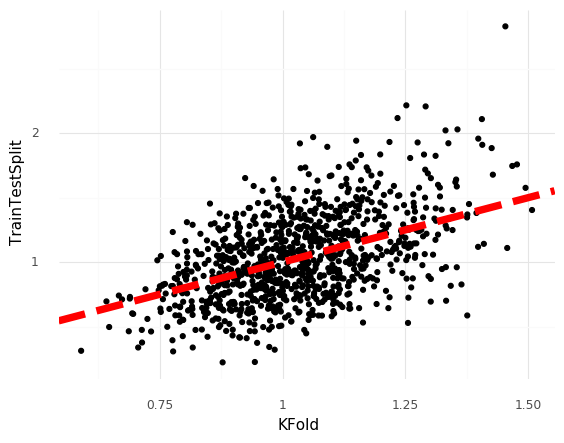

<ggplot: (8778640374023)>

In [4]:
(ggplot(dfs_concat, aes(x = "KFold", y = "TrainTestSplit")) + geom_point() +
 geom_abline(intercept = 0, slope = 1, linetype = "dashed", size = 3, color = "red") +
theme_minimal())

# the red line shows what it would look like if the data had a perfect 1 to 1 relationship

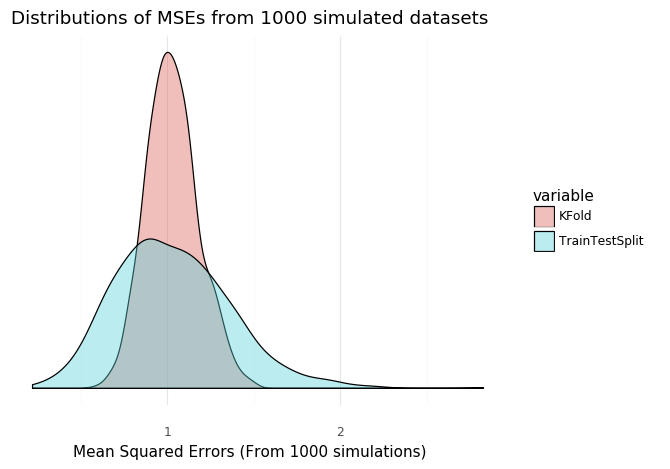

<ggplot: (8778644679897)>

In [5]:
(ggplot(dfs_long, aes(x = "value", fill = "variable")) + geom_density(alpha = 0.4, color = "black") +
 theme_minimal() + labs(x = "Mean Squared Errors (From 1000 simulations)", y = "",
                        title = "Distributions of MSEs from 1000 simulated datasets") +
theme(axis_text_y = element_blank(),
     panel_grid_major_y = element_blank(),
     panel_grid_minor_y = element_blank()))

### Reflection
All of these simulations are sampling from the SAME population and should be estimating the SAME thing: the true Test Set MSE. While typically yes, our goal is to get small MSE's (the smaller the better, even smaller than 1!), when estimating test set MSE, we want it to be close to the TRUE test-set MSE--whether that number is high or low.

This graph shows that the variability (seen by the SPREAD of the values) for TTS is much higher than KFold even though they are both centered around 1. This indicates that KFold has a more stable estimate of the test MSE, which we want! Unless computational efficiency is an issue, this gives KFold an advantage, because we are less likely to get extreme mis-estimates of the test-MSE like we are with TTS. 

This makes sense, because Kfold includes every data point in it's estimate of test MSE (because you average together all the MSEs you get) whereas TTS only includes 20% of the data. Less data usually means less percise estimates, and that shows in the above graph.

### Changing Error SD

In [6]:
dfs = [modelValidationSim(n = 1000, error_sd = 5) for i in range(1000)]
dfs_concat = pd.concat(dfs)

dfs_long = pd.melt(dfs_concat, value_vars = ["KFold", "TrainTestSplit"] )
dfs_long

,variable,value
0,KFold,27.344135
1,KFold,25.097288
2,KFold,25.648183
3,KFold,25.353701
4,KFold,24.170654
...,...,...
1995,TrainTestSplit,24.058547
1996,TrainTestSplit,21.165099
1997,TrainTestSplit,26.523686
1998,TrainTestSplit,26.824489


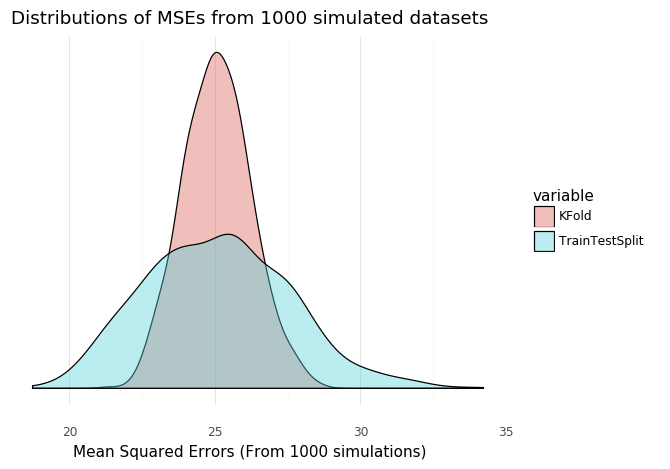

<ggplot: (8778644428258)>

In [7]:
(ggplot(dfs_long, aes(x = "value", fill = "variable")) + geom_density(alpha = 0.4, color = "black") +
 theme_minimal() + labs(x = "Mean Squared Errors (From 1000 simulations)", y = "",
                        title = "Distributions of MSEs from 1000 simulated datasets") +
theme(axis_text_y = element_blank(),
     panel_grid_major_y = element_blank(),
     panel_grid_minor_y = element_blank()))

### Reflections

Our graphs have a similar shape, but now they're centered around 25 rather than 1 (interesting...25 is 5^2...and 1 is 1^2...hmmmm).

### Changing N

In [8]:
dfs = [modelValidationSim(n = 10000) for i in range(1000)]
dfs_concat = pd.concat(dfs)

dfs_long = pd.melt(dfs_concat, value_vars = ["KFold", "TrainTestSplit"] )
dfs_long

,variable,value
0,KFold,1.018824
1,KFold,0.990429
2,KFold,0.978564
3,KFold,1.035060
4,KFold,0.988066
...,...,...
1995,TrainTestSplit,1.032734
1996,TrainTestSplit,0.985909
1997,TrainTestSplit,0.989089
1998,TrainTestSplit,1.025811


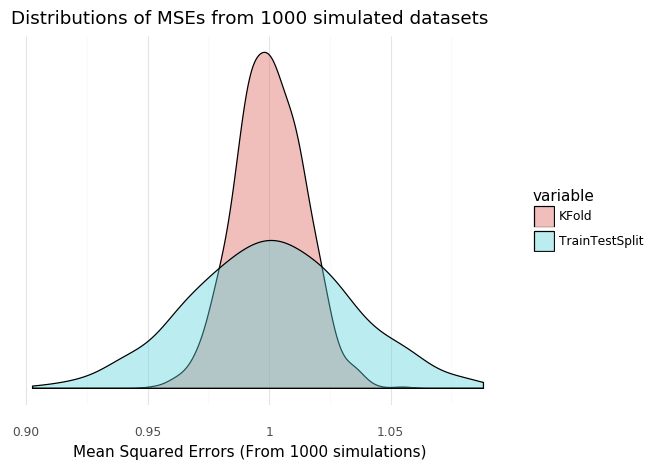

<ggplot: (8778644493276)>

In [9]:
(ggplot(dfs_long, aes(x = "value", fill = "variable")) + geom_density(alpha = 0.4, color = "black") +
 theme_minimal() + labs(x = "Mean Squared Errors (From 1000 simulations)", y = "",
                        title = "Distributions of MSEs from 1000 simulated datasets") +
theme(axis_text_y = element_blank(),
     panel_grid_major_y = element_blank(),
     panel_grid_minor_y = element_blank()))

### Reflections

Our graphs again have a similar pattern but BOTH are narrower. This is because the larger your N, the more precise your estimators will tend to be in most situations.